# Simulación de ceniza volcánica: Modelo 3D y mapa de riesgo

## 1. Contexto y objetivos
En el notebook anterior (`01_Ecuacion_Langevin.ipynb`), desarrollamos un modelo físico funcional en 2D que simula la altura y distancia de las partículas (Vista de perfil).
Sin embargo, para evaluar el **riesgo volcánico real**, necesitamos responder: ¿Qué ciudades o zonas geográficas serán afectadas?

Este notebook expande la simulación a 3 Dimensiones ($x, y, z$) para obtener una vista aérea de la dispersión.

## 2. Cambios en el modelo físico
La física subyacente (Advección-Difusión) permanece idéntica, pero vectorizamos las ecuaciones para manejar tres coordenadas:
* **Eje $x$ (Longitudinal):** Dirección principal del viento (Este-Oeste).
* **Eje $y$ (Vertical):** Altura de la columna eruptiva y caída por gravedad.
* **Eje $z$ (Transversal):** Dispersión lateral (Norte-Sur).

### Ecuación vectorial 3D
El estado de cada partícula ahora está definido por un vector $\vec{r} = (x, y, z)$. La evolución sigue la ecuación de Langevin:

$$\vec{r}_{t+1} = \vec{r}_t + \underbrace{\vec{V}(y) \cdot \Delta t}_{\text{Viento + Gravedad}} + \underbrace{\sqrt{2D\Delta t} \cdot \vec{\xi}}_{\text{Difusión Isotrópica}}$$

**Nota sobre la difusión en $z$:**
Aunque asumiremos inicialmente que el viento en $z$ es cero ($v_z = 0$), la nube se ensanchará lateralmente debido al término estocástico ($\vec{\xi}$). Esto simula cómo la turbulencia atmosférica dispersa la ceniza en todas direcciones, creando una forma de "abanico" o pluma cónica vista desde arriba.

### 3. Escala realista
A diferencia del prototipo anterior, aquí simularemos una erupción a escala real:
* **Distancias:** Kilómetros 
* **Masa:** Toneladas de ceniza
* **Tiempo:** Horas de erupción

El objetivo final es transformar puntos dispersos en un **mapa de riesgo** interpretable para la toma de decisiones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import colors

#  CONFIGURACIÓN 
N_PARTICULAS = 50000      
DT = 10.0                 # Paso de tiempo en segundos
TIEMPO_HORAS = 4          # Duración total 
TIEMPO_PASOS = int(TIEMPO_HORAS * 3600 / DT)

# Física del Volcán
MASA_TOTAL_KG = 4.0e10     # 400 Millones de kg 
ALTURA_COLUMNA = 10000.0   # 10 km de altura 
D = 600.0                # Difusión/Turbulencia 

# Inicialización
# Array de (N, 3). Columna 0=X, 1=Y, 2=Z
posiciones = np.zeros((N_PARTICULAS, 3))
posiciones[:, 1] = ALTURA_COLUMNA # Todas inician arriba

# Emisión continua durante la primera hora (3600s)
tiempos_nacimiento = np.linspace(0, 3600, N_PARTICULAS) 
en_suelo = np.zeros(N_PARTICULAS, dtype=bool)

# FUNCION VIENTO
def obtener_viento(pos_array):
    """
    Calcula la velocidad del viento en 3D para cada partícula
    """
    alturas = pos_array[:, 1] # Columna Y
    
    # EJE X: Viento con Cizalladura (Variable con altura)
    # En el suelo (y=0) -> viento=0
    # En la cima (y=6000) -> viento=25 m/s
    vx = 15.0 * (alturas / ALTURA_COLUMNA)
    
    # EJE Y: Gravedad
    # Caen a 2 m/s (Ceniza gruesa/lapilli)
    vy = np.full(len(alturas), -2.0)
    
    # EJE Z: Sin viento lateral
    # (La dispersión lateral vendrá solo del término de difusión/ruido)
    vz = np.zeros(len(alturas))
    
    return np.column_stack((vx, vy, vz))

# BUCLE DE SIMULACIÓN 

for t in range(TIEMPO_PASOS):
    t_actual = t * DT
    
    # Filtro: Solo partículas que ya nacieron y siguen volando
    activas = (tiempos_nacimiento <= t_actual) & (~en_suelo)
    
    if np.sum(activas) > 0:
        p_activas = posiciones[activas]
        
        # Advección
        viento = obtener_viento(p_activas)
        
        # Difusión (Turbulencia aleatoria en X, Y, Z)
        ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=p_activas.shape)
        
        # C. Integración (Euler)
        desplazamiento = (viento * DT) + ruido
        posiciones[activas] += desplazamiento
        
        # D. Condiciones de Frontera (Suelo)
        # Chequeamos si bajaron de 0 en el eje Y
        suelo_mask = (posiciones[:, 1] <= 0) & activas
        
        # Las "pegamos" al suelo
        posiciones[suelo_mask, 1] = 0.0 
        en_suelo[suelo_mask] = True


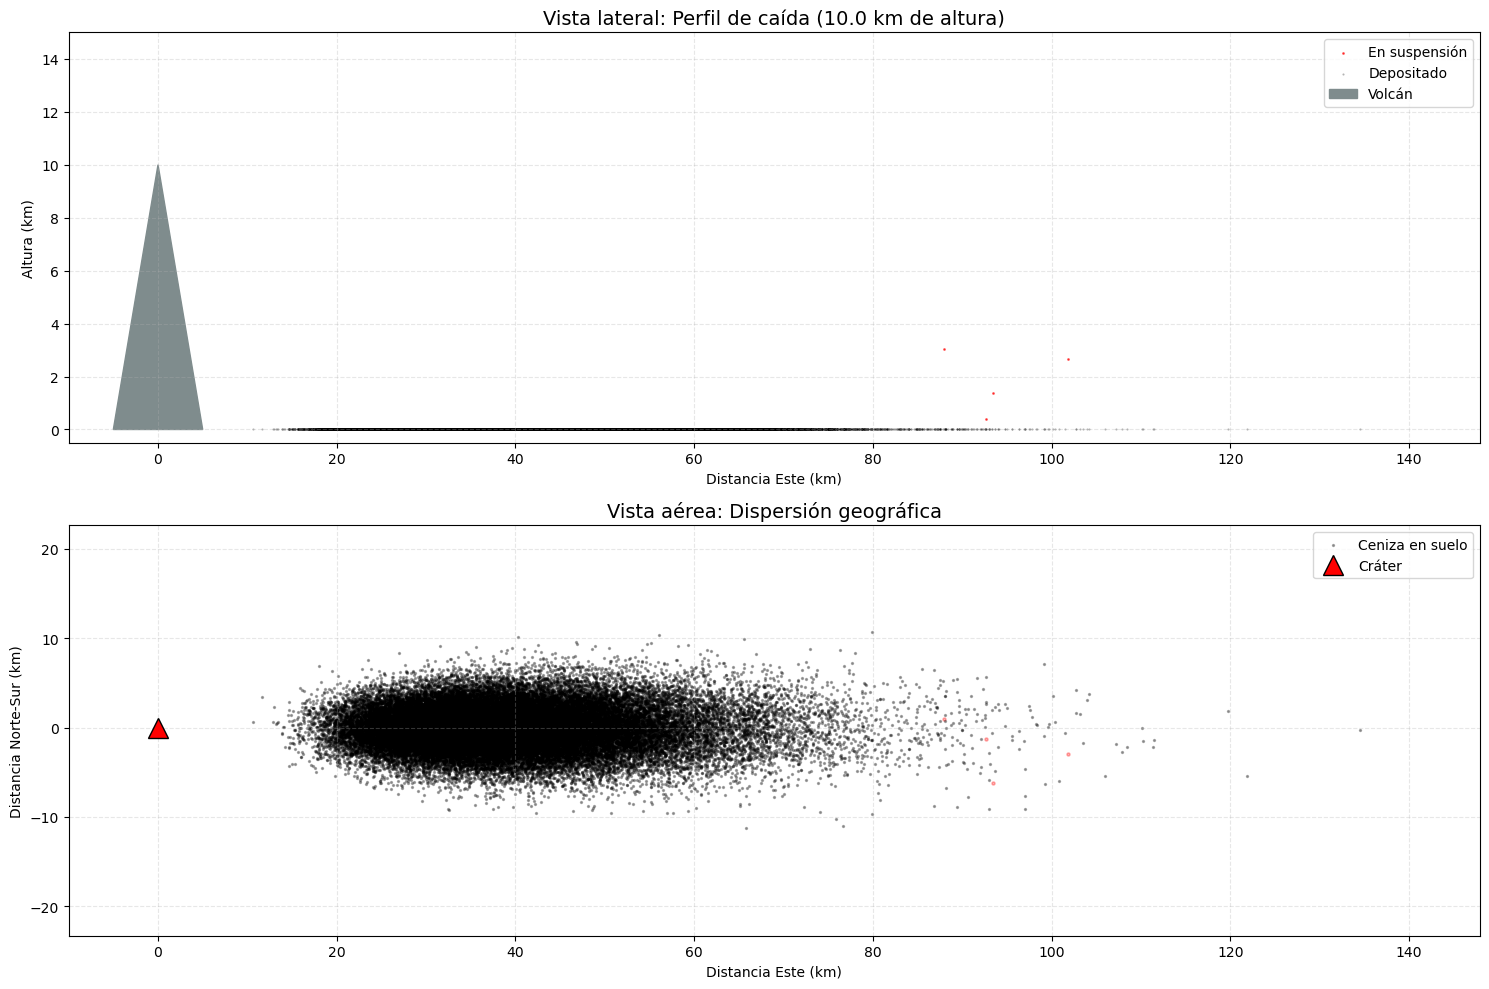

In [2]:
# VISUALIZACIÓN 
plt.figure(figsize=(15, 10))

# Conversión de metros a Kilómetros para lectura fácil
x_km = posiciones[:, 0] / 1000
y_km = posiciones[:, 1] / 1000
z_km = posiciones[:, 2] / 1000
altura_volcan_km = ALTURA_COLUMNA / 1000

# VISTA DE PERFIL (Lateral)
plt.subplot(2, 1, 1)
plt.title(f"Vista lateral: Perfil de caída ({altura_volcan_km} km de altura)", fontsize=14)

# Dibujamos la ceniza
# Nube en aire (Rojo) - Usamos s=10 para que se noten si quedan pocas
plt.scatter(x_km[~en_suelo], y_km[~en_suelo], c='red', s=1, alpha=0.6, label='En suspensión')
# Ceniza en suelo (Negro)
plt.scatter(x_km[en_suelo], y_km[en_suelo], c='black', s=1, alpha=0.3, marker='.', label='Depositado')

# Dibujamos el volcán
plt.fill([-5, 0, 5], [0, altura_volcan_km, 0], color='#7f8c8d', label='Volcán') 

# Detalles del gráfico
plt.ylabel("Altura (km)")
plt.xlabel("Distancia Este (km)")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)


plt.ylim(-0.5, altura_volcan_km * 1.5) 
plt.xlim(-10, np.max(x_km) * 1.1)


# VISTA AÉREA 
plt.subplot(2, 1, 2) 
plt.title("Vista aérea: Dispersión geográfica", fontsize=14)

# Ceniza
plt.scatter(x_km[~en_suelo], z_km[~en_suelo], c='red', s=5, alpha=0.3)
plt.scatter(x_km[en_suelo], z_km[en_suelo], c='black', s=2, alpha=0.3, label='Ceniza en suelo')

# Volcán
plt.plot(0, 0, 'r^', markersize=15, markeredgecolor='k', label='Cráter') 


plt.ylabel("Distancia Norte-Sur (km)")
plt.xlabel("Distancia Este (km)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.axis('equal')


plt.xlim(-10, np.max(x_km) * 1.1)
plt.ylim(np.min(z_km)*1.2, np.max(z_km)*1.2) 

plt.tight_layout()
plt.show()

## Procesamiento de datos: Transformación Lagrangiana a Euleriana

Hasta este punto, nuestra simulación ha sido **Lagrangiana**: hemos rastreado la trayectoria individual de cada partícula ($\vec{r}_i$). Sin embargo, para evaluar el riesgo en una ciudad o zona de cultivo, no nos interesa saber "dónde está la partícula, sino "cuánta masa total cayó en este kilómetro cuadrado".

Para lograr esto, realizamos una transformación a un enfoque **Euleriano** (basado en una rejilla fija):

1.  **Discretización (Binning):** Dividimos el terreno en una cuadrícula de celdas de tamaño fijo (ej. $1 \times 1$ km).
2.  **Agregación:** Sumamos la masa de todas las partículas que cayeron dentro de cada celda usando un histograma 2D.
3.  **Cálculo de Carga:** Convertimos el conteo de partículas a densidad física ($kg/m^2$).

$$\text{Carga} (kg/m^2) = \frac{\text{Conteo en celda} \times \text{Masa por partícula}}{\text{Área de la celda}}$$

In [3]:
# Objetivo: Convertir puntos dispersos (Lagrangiano) en una malla de densidad (Euleriano).

# Extraer coordenadas de la ceniza en el suelo
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# 2. Definir la rejilla
# Queremos un mapa de 100km x 40km
RANGO_X = [0, 100000]     
RANGO_Z = [-20000, 20000] 
BINS = 100 # Resolución de 100x100 cuadros

# Histograma 2D
conteo, _, _ = np.histogram2d(x_suelo, z_suelo, bins=BINS, range=[RANGO_X, RANGO_Z])

# Convertir a unidades reales (kg/m^2)
masa_por_particula = MASA_TOTAL_KG / N_PARTICULAS
area_celda = ((RANGO_X[1]-RANGO_X[0])/BINS) * ((RANGO_Z[1]-RANGO_Z[0])/BINS)
mapa_crudo = (conteo * masa_por_particula) / area_celda

# Corrección estadística (Filtro Gaussiano; convierte el ruido pixelado en una nube continua realista)
mapa_suave = gaussian_filter(mapa_crudo, sigma=1.5)

print(f"Carga MÁXIMA detectada: {np.max(mapa_suave):.2f} kg/m^2")


Carga MÁXIMA detectada: 246.56 kg/m^2


### Corrección estadística: Estimación de densidad (KDE)

Al proyectar un número finito de partículas (30,000) sobre una cuadrícula extensa, es normal encontrar ruido de muestreo:
* Celdas vacías adyacentes a celdas con mucha masa.
* Picos artificiales de acumulación debido al azar.

En la realidad, una nube de ceniza es un medio continuo, no un conjunto de puntos discretos. Para recuperar la continuidad física y mitigar el error de muestreo, aplicamos un filtro gaussiano (`Gaussian Filter`).

> **Nota Técnica:** Esto actúa como una *Kernel Density Estimation (KDE)* simplificada. Matemáticamente, redistribuye la masa de cada celda hacia sus vecinas basándose en una distribución normal, suavizando los artefactos numéricos sin alterar la masa total del sistema.

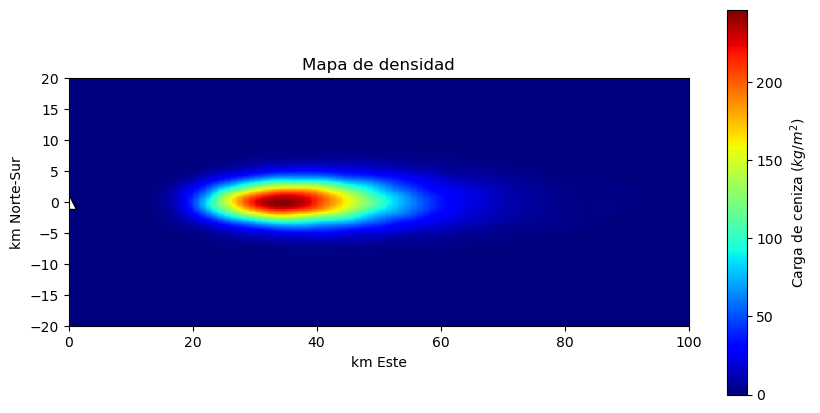

In [4]:
# VISUALIZACIÓN CONTINUA (Mapa de Calor)
# Sirve para ver gradientes y la dirección del viento.

plt.figure(figsize=(10, 5))

plt.imshow(mapa_suave.T, origin='lower', cmap='jet', 
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000])

plt.colorbar(label='Carga de ceniza ($kg/m^2$)')
plt.plot(0, 0, 'w^', markersize=10, markeredgecolor='k', label='Volcán')
plt.title("Mapa de densidad")
plt.xlabel("km Este")
plt.ylabel("km Norte-Sur")
plt.show()

## 3. Clasificación del riesgo

El mapa anterior nos muestra *dónde* hay ceniza, pero no nos dice qué tan grave es. En gestión de riesgos, se utlizan umbrales específicos para tomar decisiones.

Basándonos en estándares vulcanológicos (ej. USGS), clasificamos la acumulación en **4 Zonas de Impacto**:

| Zona (Color) | Carga ($kg/m^2$) | Impacto Esperado |
| :--- | :--- | :--- |
| **Verde** | 1 - 10 | **Molestia:** Aeropuertos cerrados, limpieza necesaria. |
| **Amarillo** | 10 - 100 | **Daño económico:** Pérdida de cultivos, daño a motores. |
| **Naranja** | 100 - 300 | **Daño estructural:** Riesgo para techos débiles. |
| **Rojo** | > 300 | **Colapso:** Destrucción de techos, peligro mortal. |

A continuación, convertimos nuestro gradiente continuo en un mapa de zonas discretas.

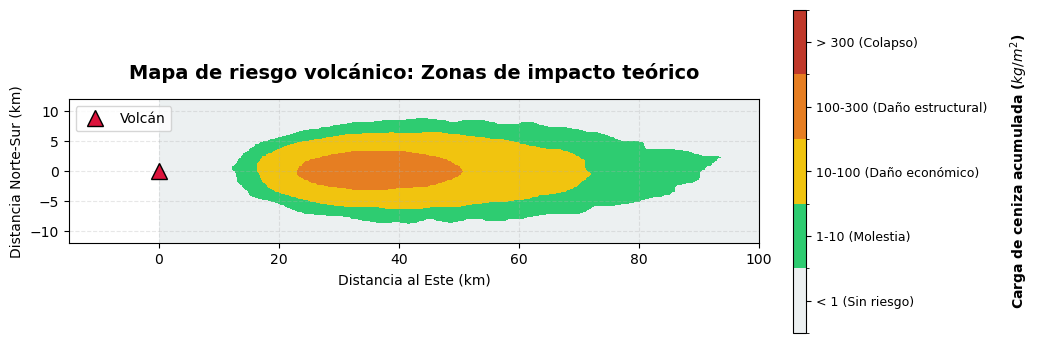

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import numpy as np

# VISUALIZACIÓN DISCRETA

os.makedirs('./assets', exist_ok=True)


plt.figure(figsize=(11, 6)) 

# Definición de niveles y colores
niveles = [0, 1, 10, 100, 300, 5000] 
colores = ['#ecf0f1', '#2ecc71', '#f1c40f', '#e67e22', '#c0392b'] 
cmap_riesgo = colors.ListedColormap(colores)
norma = colors.BoundaryNorm(niveles, cmap_riesgo.N)


img = plt.imshow(mapa_suave.T, origin='lower', 
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000],
           cmap=cmap_riesgo, norm=norma)

# Ajuste de aspecto 1:1 y zoom vertical
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(-12, 12) 

# Configurar la barra de color
cbar = plt.colorbar(img, spacing='uniform', shrink=0.7, aspect=25, pad=0.04)
cbar.set_label('Carga de ceniza acumulada ($kg/m^2$)', fontsize=10, labelpad=15, fontweight='bold')


ticks_reales = [
    0.5,    # Mitad entre 0 y 1
    5.5,    # Mitad entre 1 y 10
    55,     # Mitad entre 10 y 100
    200,    # Mitad entre 100 y 300
    2650    # Mitad entre 300 y 5000
]
cbar.set_ticks(ticks_reales)

# Etiquetas
etiquetas_leyenda = [
    '< 1 (Sin riesgo)', 
    '1-10 (Molestia)', 
    '10-100 (Daño económico)', 
    '100-300 (Daño estructural)', 
    '> 300 (Colapso)'
]
cbar.ax.set_yticklabels(etiquetas_leyenda, fontsize=9)


plt.plot(0, 0, '^', color='crimson', markeredgecolor='black', markersize=12, label='Volcán')
plt.xlim(-15, RANGO_X[1]/1000) 

plt.title("Mapa de riesgo volcánico: Zonas de impacto teórico", fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Distancia al Este (km)", fontsize=10)
plt.ylabel("Distancia Norte-Sur (km)", fontsize=10)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)

# 6. Guardar
plt.savefig('./assets/mapa_riesgo_final.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusiones y próximos pasos

## Resumen del proyecto
En este notebook, hemos logrado escalar un modelo físico simple (Langevin 2D) a una herramienta de simulación geoespacial completa. Hemos conseguido:
1.  **Simular la física:** Reproducir el transporte de ceniza volcánica bajo efectos de advección (viento) y difusión (turbulencia).
2.  **Procesar datos:** Transformar trayectorias de partículas individuales en mapas de densidad de carga ($kg/m^2$).
3.  **Evaluar riesgo:** Aplicar umbrales internacionales (USGS) para identificar zonas de colapso estructural y daño económico.

## Limitaciones del modelo
Aunque los resultados son visualmente coherentes, este modelo asume:
* **Viento constante:** En la realidad, el viento cambia de dirección con el tiempo y la altura (perfiles de viento complejos).
* **Topografía plana:** No consideramos montañas que podrían bloquear la ceniza.
* **Partícula única:** Asumimos un tamaño de partícula promedio, cuando en realidad hay una distribución granulométrica.

Para convertir esto en un producto de producción real, los siguientes pasos serían:
* Integrar datos meteorológicos reales (API de vientos NOAA).
* Superponer los resultados en un mapa real (usando librerías como `Folium` o `GeoPandas`).